# Get data

Downloading the data

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("downloads", "datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_data(url, path):
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, url.split('/')[-1])
    urllib.request.urlretrieve(url, tgz_path)
    data_tgz = tarfile.open(tgz_path, "r")
    data_tgz.extractall(path=path)
    data_tgz.close()
    

In [2]:
fetch_data(HOUSING_URL, HOUSING_PATH)

In [3]:
import pandas as pd

def load_data(path):
    return pd.read_csv(path)

In [4]:
data = load_data(os.path.join(HOUSING_PATH, "housing.csv"))

# Lear data

In [5]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


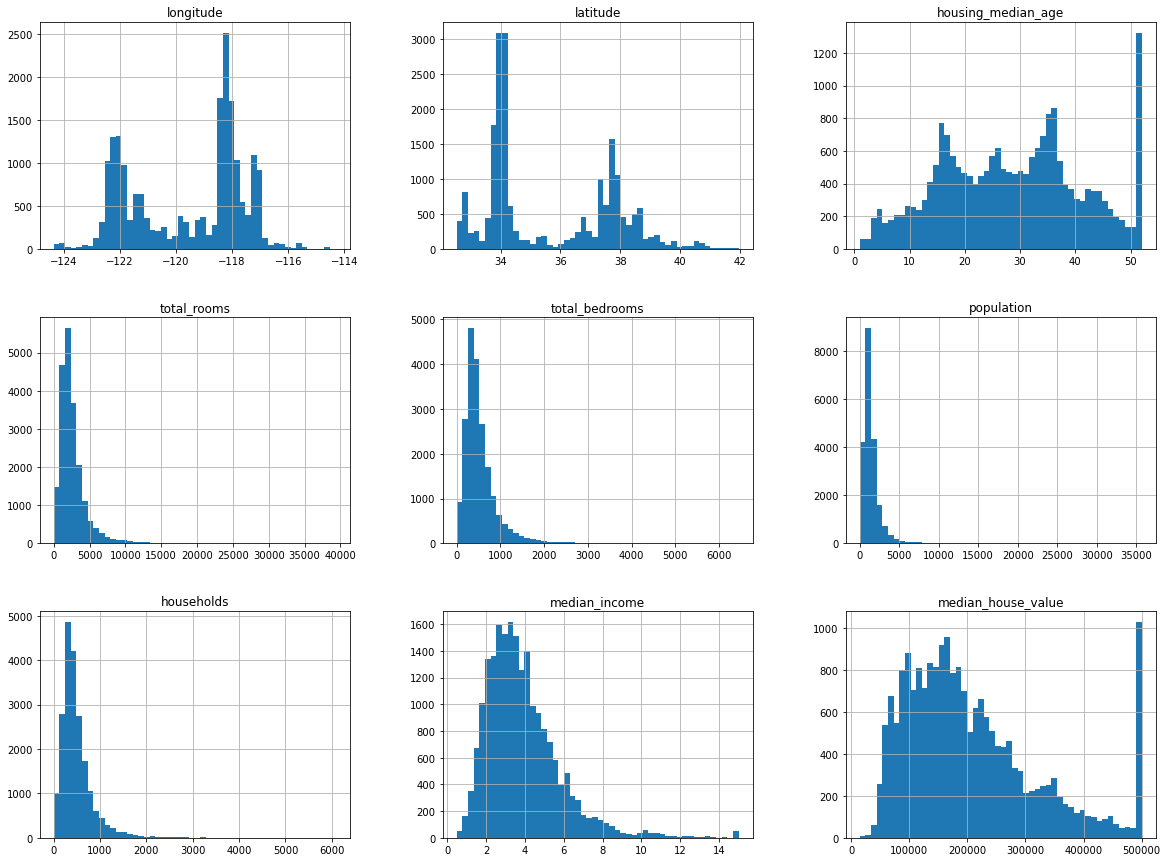

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# will plot numerical data histograms, 
# bins - into how many gropus 
data.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
import numpy as np

# this will generate different datasets for cases when
# we will add new instances to dataset (even thoush static seed)
np.random.seed(42)
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [11]:
train_set, test_set = split_train_test(data, 0.2)
print(f"Sizeof trainig set - {len(train_set)}")
print(f"Sizeof test set - {len(test_set)}")

Sizeof trainig set - 16512
Sizeof test set - 4128


In [12]:
from zlib import crc32

# this will create same datasets no matter what
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]

    # for all values in pandas series (here id_) apply lambda funcion
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) 
    
    # ~ stands for bitwise no
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
# adds an "index" column (unique key for every entry)
data_with_id = data.reset_index()

train_set, test_set = split_train_test_by_id(data_with_id, 0.2, "index")

In [14]:
# but if new data won't be appended after old one, this still
# will cause different sets over time (thus different ids)

# we can combine unique feautures to create static id ex here:
data_with_id.drop("index", axis=1, inplace=True)

data_with_id["id"] = data["longitude"] * 1000 + data["latitude"]
data_with_id["id"].head(4)

0   -122192.12
1   -122182.14
2   -122202.15
3   -122212.15
Name: id, dtype: float64

In [15]:
from sklearn.model_selection import train_test_split

# using sklear built-in functions
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

<AxesSubplot:>

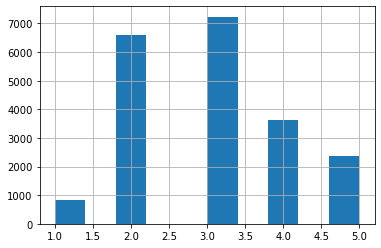

In [16]:
# creating income category with 5 statums (labeled form 1 to 5) 
# with ranges defined in bins

data["income_cat"] = pd.cut(data["median_income"],
                           bins=[0., 1.5, 3., 4.5, 6., np.inf],
                           labels=[1, 2, 3, 4, 5])
data["income_cat"].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# spliting data using stratified sampling based on income_cat

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

In [18]:
# % of each stratum in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [19]:
# % of each stratum in the trainig set
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [20]:
# we don't need income_cat anymore - it has done its job, drop it
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

/var/folders/w6/pmft1xts6rz0ks3n99d53hfr0000gn/T/ipykernel_17945/442191170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
/var/folders/w6/pmft1xts6rz0ks3n99d53hfr0000gn/T/ipykernel_17945/442191170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [21]:
# create copy to play with it 

train_vis = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

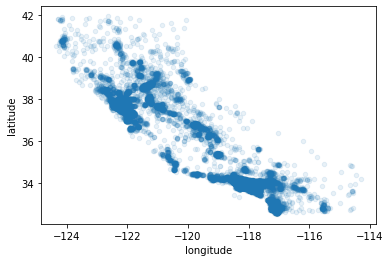

In [22]:
train_vis.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

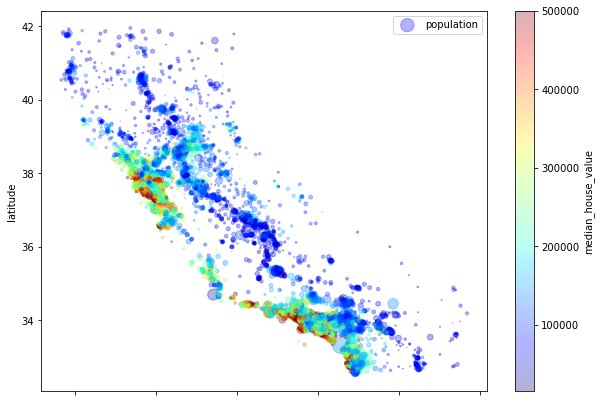

In [23]:
# here instad of just "population" we use train_vis["population"] / 100
# to make dots smaller

# dot location defined by x and y
# s - dot size (bigger val - bigger dot)
# c - dot color (bigger val - more red)

train_vis.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
             s=train_vis["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [24]:
corr_matrix = train_vis.corr()

In [25]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

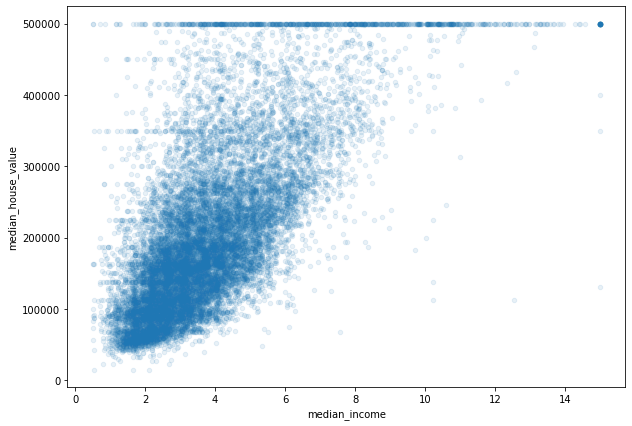

In [26]:
train_vis.plot(kind="scatter", x="median_income", y="median_house_value",
              figsize=(10, 7), alpha=0.1)

# here we can see a quirk lines around 500k, 350k, 230k that
# we might want to remove before the training

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

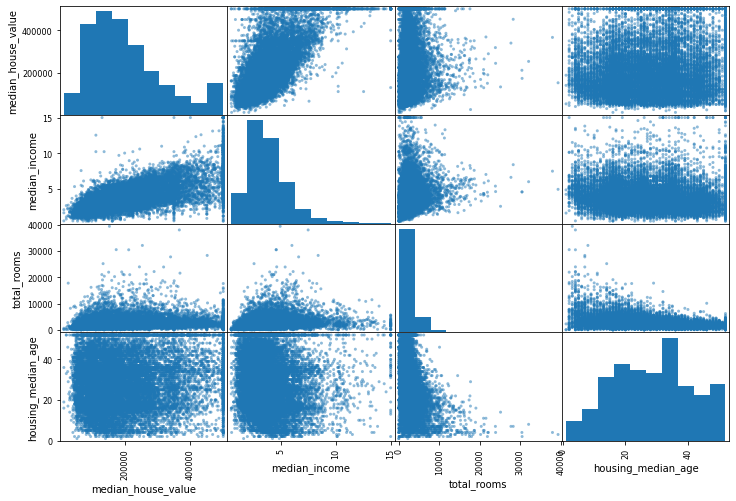

In [27]:
from pandas.plotting import scatter_matrix

# we will only plot it for a couple attributes, scince it plots
# every attribute agains rest of them, so number of plots is quadratic

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(train_vis[attributes], figsize=(12,8))

# on the main diagonal there is a histogram of 
# each attribute

In [28]:
# lets create some perhaps useful feautures
train_vis["rooms_per_household"] = train_vis["total_rooms"] / train_vis["households"]
train_vis["bedrooms_per_room"] = train_vis["total_bedrooms"] / train_vis["total_rooms"]
train_vis["population_per_household"] = train_vis["population"] / train_vis["households"]

In [29]:
corr_matrix = train_vis.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Clean data

In [30]:
data = strat_train_set.drop("median_house_value", axis=1)
data_labels = strat_train_set["median_house_value"]

In [31]:
# total bedrooms has missing values
# note that these functions returns the copy of a dataFrame

# opt 1 - drop rows with missing values
data.dropna(subset=["total_bedrooms"])

# opt 2 - drop entire attribute
data.drop("total_bedrooms", axis = 1)

# opt 3 - fill them with some value
median = data["total_bedrooms"].median()
data["total_bedrooms"].fillna(median)

12655     797.0
15502     855.0
2908      310.0
14053     519.0
20496     646.0
          ...  
15174    1231.0
12661    1422.0
19263     166.0
19140     580.0
19773     222.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [32]:
# lets go for 3rd option
data["total_bedrooms"].fillna(median, inplace=True)

# remember that we will need to fill empty falues in
# test set and new instances with exact median we are using there

In [33]:
from sklearn.impute import SimpleImputer

# it can be done with sklearn (here it will replace all empty vals
# with medians of corresponding attribute, so we have to feed it
# only with numeric values)

imputer = SimpleImputer(strategy="median")
data_num = data.drop("ocean_proximity", axis=1)
imputer.fit(data_num)

SimpleImputer(strategy='median')

In [34]:
# to automate it

# Boolean, unsigned integer, signed integer, float, complex.
_NUMERIC_KINDS = set('buifc')

no_numeric = []
for attr in data:
    if data[attr].dtype.kind not in _NUMERIC_KINDS:
        no_numeric.append(attr)

data_num = data.drop(no_numeric, axis=1)
imputer.fit(data_num)

SimpleImputer(strategy='median')

In [35]:
# here imputer has calculated the mean of every numeric val
# and saved it
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [36]:
# it returns a numpy array
X = imputer.transform(data_num)

# back to pd.DataFrame
data_num_tr = pd.DataFrame(X, columns=data_num.columns,
                          index=data_num.index)

In [37]:
# leats deal with no-numeric attributes
data_cat = data[no_numeric]

In [38]:
data_cat.head(4)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN


In [39]:
from sklearn.preprocessing import OrdinalEncoder

# lets encode them into numbers
ordinal_encoder = OrdinalEncoder()

# it learns and trainforms at once, again returning numpy array
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)
data_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
from sklearn.preprocessing import OneHotEncoder

# this encoding might be good for categories like 'bad', 'average', 'good'
# because ML models will correlate them, but in our case we dont want it
# let's use one-hot-encoding

# note: it returns a SciPy sparse matrix, with only holds locations
# of non-zero values
cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(data_cat)

# data_cat_1hot.to_array() if we want it to be numpy array

In [42]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
data_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom transformer that adds rooms_per_household... that
# we hard-coded earlier

# this won't work with pipline, scince it passes np.arrays not
# pd.DataFrames to class call
class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X["total_rooms"] / X["households"]
        bedrooms_per_room = X["total_bedrooms"] / X["total_rooms"]
        population_per_household = X["population"] / X["households"]
        return X.assign(rooms_per_household=rooms_per_household, bedrooms_per_room=bedrooms_per_room, population_per_household=population_per_household)
    
attr_adder = CombinedAttributeAdder()
data_extra_attribs = attr_adder.transform(data)

In [45]:
# version for np.arrays

class CombinedAttributeAdder2(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.rooms_idx = 3
        self.bedrooms_idx = 4
        self.population_idx = 5
        self.household_idx = 6
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, self.rooms_idx] / X[:, self.household_idx]
        population_per_household = X[:, self.population_idx] / X[:, self.household_idx]
        bedrooms_per_room = X[:, self.bedrooms_idx] / X[:, self.rooms_idx]
        
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# using piplines to organise preprocessing steps
# note that all passed estimators needs to have fit_transform method
num_pipline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("attribs_adder", CombinedAttributeAdder2()),
    ("std_scaler", StandardScaler())
])

data_num_tr = num_pipline.fit_transform(data_num)

In [47]:
def split_attribs(data):
    _NUMERIC_KINDS = set('buifc')
    num_attribs = []
    cat_attribs = []

    for attrib in data:
        if data[attrib].dtype.kind in _NUMERIC_KINDS:
            num_attribs.append(attrib)
        else:
            cat_attribs.append(attrib)
    
    return num_attribs, cat_attribs

In [49]:
from sklearn.compose import ColumnTransformer

# lets fit all into one pipline
num_attribs, cat_attribs = split_attribs(data)

full_pipeline = ColumnTransformer([
    ("num", num_pipline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

data_prep = full_pipeline.fit_transform(data)

# instad of using a transformer we can pass strings:
# - drop - if we want column to be droped
# - passthrough - if we want column to be untouched
# by default all columns that aren't listed by us will be dropped

# Training and evaluating on the training set

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_prep, data_labels)

LinearRegression()

In [51]:
some_data = data.iloc[:5]
some_labels = data_labels.iloc[:5]
some_data_prep = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prep))
print("Labels: ", list(some_labels))

Predictions:  [ 86208. 304704. 153536. 185728. 244416.]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [52]:
from sklearn.metrics import mean_squared_error

data_pred = lin_reg.predict(data_prep)
lin_mse = mean_squared_error(data_labels, data_pred)
lin_rmse = np.sqrt(lin_mse)

lin_rmse
# typical prediction error is around 68630 USD, so model 
# underfits the data

68633.40810776998

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(data_prep, data_labels)

DecisionTreeRegressor(random_state=42)

In [54]:
data_pred = tree_reg.predict(data_prep)
tree_mse = mean_squared_error(data_labels, data_pred)
tree_rmse = np.sqrt(tree_mse)

tree_rmse
# here model crealy overfits the data

0.0

In [55]:
from sklearn.model_selection import cross_val_score

# better evaluation with Cross-Validation
scores = cross_val_score(tree_reg, data_prep, data_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [56]:
def display_scores(scores):
    # note - lower means betterb
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [57]:
def cross_rmse(model, data, data_labels, cv=10):
    return np.sqrt(-cross_val_score(model, data, data_labels,
                                   scoring="neg_mean_squared_error",
                                    cv=cv))

lin_rmse_scores = cross_rmse(lin_reg, data_prep, data_labels)
display_scores(lin_rmse_scores)

Scores: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
Mean: 69116.4347200802
Standard deviation: 2880.6588594759014


In [58]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(data_prep, data_labels)
forest_rmse_scores = cross_rmse(forest_reg, data_prep, data_labels)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [59]:
def get_rmse(model, data, data_labels):
    from sklearn.metrics import mean_squared_error
    
    data_pred = model.predict(data)
    return np.sqrt(mean_squared_error(data_labels, data_pred))

In [60]:
# and forest scores on the training set
forest_rmse = get_rmse(forest_reg, data_prep, data_labels)
forest_rmse

# note that score on the training set is lower than on a 
# validation sets, so model is still overfitting 

18650.698705770003

In [61]:
# saving model

def save(model, name, path=[]):
    import joblib, os
    path = os.path.join(*path)
    os.makedirs(path, exist_ok=True)
    path = os.path.join(path, name+".pkl")
    joblib.dump(model, path)
def load(name, path=[]):
    import joblib, os
    path = os.path.join(*path, name+".pkl")
    joblib.load(path)

save(forest_reg, "forest", ["models", "chapter2"])

In [62]:
forest_reg = load("forest", ["models", "chapter2"])

# Fine-tuning hyperparams

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30, 40], "max_features": [3, 4, 6, 8, 10, 12]},
    {"bootstrap": [False], "n_estimators": [3, 10, 30], "max_features": [2, 3, 4, 5]},
]

forest_reg = RandomForestRegressor(random_state=42)

# n_jobs=-1 - use all possible cores
# refit=True tells grid to train the best estimator on the entire training set
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          return_train_score=True, refit=True,
                          n_jobs=-1)
grid_search.fit(data_prep, data_labels)

# cv - it will train each model 5 times
# for first opt it will make 4 x 6 different models (each one trained 5 times)
# for second opt it will make 3 x 4

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [3, 4, 6, 8, 10, 12],
                          'n_estimators': [3, 10, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4, 5],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 30}

In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62138.771592441655 {'max_features': 3, 'n_estimators': 3}
54325.48492466751 {'max_features': 3, 'n_estimators': 10}
51518.32314375803 {'max_features': 3, 'n_estimators': 30}
51137.58589103247 {'max_features': 3, 'n_estimators': 40}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
49868.78117278373 {'max_features': 4, 'n_estimators': 40}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
49785.86881399506 {'max_features': 6, 'n_estimators': 40}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
49738.68308638107 {'max_features': 8, 'n_estimators': 40}
57829.69975338175 {'max_features': 10, 'n_estimators': 3}
52021.96352281818

In [66]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.130080,0.003946,0.005712,0.000595,3,3,NaN,"{'max_features': 3, 'n_estimators': 3}",-3.801161e+09,-4.162663e+09,...,-3.861227e+09,2.072337e+08,35,-1.025509e+09,-1.092792e+09,-9.940960e+08,-9.776993e+08,-1.003100e+09,-1.018639e+09,4.016414e+07
1,0.399749,0.006368,0.015881,0.002176,3,10,NaN,"{'max_features': 3, 'n_estimators': 10}",-2.946161e+09,-2.966944e+09,...,-2.951258e+09,8.046572e+07,25,-5.484950e+08,-5.673961e+08,-5.373780e+08,-5.483462e+08,-5.677743e+08,-5.538779e+08,1.189684e+07
2,1.131685,0.006865,0.040604,0.001439,3,30,NaN,"{'max_features': 3, 'n_estimators': 30}",-2.648150e+09,-2.568034e+09,...,-2.654138e+09,9.148622e+07,16,-4.071473e+08,-4.071182e+08,-4.013702e+08,-4.054223e+08,-4.066314e+08,-4.055379e+08,2.175630e+06
3,1.515590,0.016813,0.057164,0.004858,3,40,NaN,"{'max_features': 3, 'n_estimators': 40}",-2.622164e+09,-2.550476e+09,...,-2.615053e+09,8.346339e+07,14,-3.938038e+08,-3.934429e+08,-3.863967e+08,-3.866466e+08,-3.889160e+08,-3.898412e+08,3.212491e+06
4,0.149736,0.003522,0.004777,0.000402,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,34,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
5,0.481206,0.004400,0.013993,0.000815,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,22,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
6,1.423402,0.004820,0.042165,0.001902,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,11,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
7,1.896543,0.006792,0.053518,0.003892,4,40,NaN,"{'max_features': 4, 'n_estimators': 40}",-2.503883e+09,-2.408459e+09,...,-2.486895e+09,8.381686e+07,5,-3.635658e+08,-3.767414e+08,-3.794185e+08,-3.693560e+08,-3.748826e+08,-3.727929e+08,5.671131e+06
8,0.194541,0.003828,0.004496,0.000310,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,29,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
9,0.650960,0.007987,0.014790,0.000863,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,17,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06


In [67]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30,
                      random_state=42)

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# randomized search might be a better option than we've a lot of
# possile params values or we don't know best range

param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=10),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=30, cv=5, scoring="neg_mean_squared_error", random_state=42,
                               n_jobs=-1)
rnd_search.fit(data_prep, data_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x134623f70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1345cf130>},
                   random_state=42, scoring='neg_mean_squared_error')

In [69]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
49219.78661183016 {'max_features': 8, 'n_estimators': 189}
49507.55612836882 {'max_features': 5, 'n_estimators': 103}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
49268.4058713683 {'max_features': 8, 'n_estimators': 117}
49488.86752740511 {'max_features': 4, 'n_estimators': 104}
49279.60778024525 {'max_features': 8, 'n_estimators': 131}
49628.9978756492 {'max_features': 6, 'n_estimators': 53}
51791.826463777696 {'max_features': 2, 'n_estimators': 88}
49304.50722820199 {'max_features': 6, 'n_estimators': 130}
49214.73091010895 {'max_features': 5, 'n_estimators': 161}
49375.34732138837 {'max_features': 6, 'n_estimators': 89}
54450.30065647209 {'max_features': 1, 'n_estimators': 59}
50469.04171112333 {'max_features': 3, 'n_estimators': 108}
49500.77440729182 {'max_features': 7, 'n_estimators': 64}
49437.85526744786 {'max_features': 9, 'n_estimators': 131}
49921.48934549236 {'max_features': 5, 'n_estimators': 51}
5039

# Analyze best models

In [70]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.91984391e-02, 8.88723156e-02, 4.05829583e-02, 2.06241438e-02,
       1.95292684e-02, 2.16237052e-02, 1.86767678e-02, 2.66411110e-01,
       6.76695870e-02, 1.01200934e-01, 9.67239988e-02, 1.61438797e-02,
       1.37922943e-01, 5.01131709e-05, 8.44320576e-03, 6.32663150e-03])

In [71]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.2664111098152523, 'median_income'),
 (0.137922942547392, 'NEAR OCEAN'),
 (0.10120093351621784, 'INLAND'),
 (0.0967239987960382, 'ISLAND'),
 (0.08919843911811266, 'longitude'),
 (0.08887231564404374, 'latitude'),
 (0.06766958695335187, '<1H OCEAN'),
 (0.040582958251193034, 'housing_median_age'),
 (0.021623705203002466, 'population'),
 (0.020624143804792595, 'total_rooms'),
 (0.019529268405750158, 'total_bedrooms'),
 (0.018676767806356895, 'households'),
 (0.016143879709792225, 'NEAR BAY')]

# Evaluate on the test set

In [77]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prep = full_pipeline.transform(X_test)

final_rmse = get_rmse(final_model, X_test_prep, y_test)
final_rmse

46438.27274577476

In [80]:
from scipy import stats

# computing condfidence interval
condfidence = 0.95
final_predictions = final_model.predict(X_test_prep)

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(condfidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([44517.47863763, 48282.71374902])

# Exerices

In [99]:
from sklearn.svm import SVR

param_grid = [
    {"kernel": ["linear"], "C": [1., 10., 50., 100., 500., 1000., 3000., 10000., 30000.]},
    {"kernel": ["rbf"], "C": [1., 10., 50., 100., 500., 1000., 3000., 10000., 30000.], "gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()
svm_grid = GridSearchCV(svm_reg, param_grid=param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          refit=True, n_jobs=-1, verbose=2)

svm_grid.fit(data_prep, data_labels)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

[CV] END ..............................C=10.0, kernel=linear; total time=  14.4s
[CV] END ..............................C=50.0, kernel=linear; total time=  12.9s
[CV] END .............................C=100.0, kernel=linear; total time=  13.8s
[CV] END ............................C=1000.0, kernel=linear; total time=  13.0s
[CV] END ............................C=3000.0, kernel=linear; total time=  13.7s
[CV] END ...........................C=30000.0, kernel=linear; total time=  23.8s
[CV] END ......................C=1.0, gamma=0.03, kernel=rbf; total time=  21.4s
[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=  20.8s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=  19.5s
[CV] END .......................C=1.0, gamma=3.0, kernel=rbf; total time=  19.1s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  20.9s
[CV] END ......................C=10.0, gamma=0.3, kernel=rbf; total time=  20.1s
[CV] END ...................

[CV] END ...............................C=1.0, kernel=linear; total time=  14.8s
[CV] END ..............................C=50.0, kernel=linear; total time=  12.8s
[CV] END .............................C=500.0, kernel=linear; total time=  14.1s
[CV] END ............................C=1000.0, kernel=linear; total time=  13.0s
[CV] END ...........................C=10000.0, kernel=linear; total time=  17.1s
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=  20.5s
[CV] END ......................C=1.0, gamma=0.03, kernel=rbf; total time=  21.2s
[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=  20.8s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=  19.5s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  21.1s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  20.8s
[CV] END ......................C=10.0, gamma=0.3, kernel=rbf; total time=  20.1s
[CV] END ...................

[CV] END ...............................C=1.0, kernel=linear; total time=  14.9s
[CV] END ..............................C=50.0, kernel=linear; total time=  13.1s
[CV] END .............................C=500.0, kernel=linear; total time=  14.1s
[CV] END ............................C=3000.0, kernel=linear; total time=  14.2s
[CV] END ...........................C=10000.0, kernel=linear; total time=  16.2s
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=  20.5s
[CV] END ......................C=1.0, gamma=0.03, kernel=rbf; total time=  21.1s
[CV] END .......................C=1.0, gamma=0.3, kernel=rbf; total time=  20.3s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=  19.6s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  21.1s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  20.9s
[CV] END ......................C=10.0, gamma=0.3, kernel=rbf; total time=  20.2s
[CV] END ...................

In [101]:
svm_reg = svm_grid.best_estimator_

get_rmse(svm_reg, X_test_prep, y_test)

55399.10179320519

In [105]:
svm_reg = SVR()

param_distribs = {
    "kernel": ["linear", "rbf"],
    "C": randint(low=1, high=50000),
    "gamma": randint(low=1, high=10),
}

rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=50, cv=5, scoring="neg_mean_squared_error", random_state=42,
                               n_jobs=-1, verbose=2)
rnd_search.fit(data_prep, data_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17d1d52d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17d1d7670>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [106]:
svm_reg = rnd_search.best_estimator_

get_rmse(svm_reg, X_test_prep, y_test)

68250.07436416502

In [108]:
from scipy.stats import reciprocal, expon
from time import time

# let's use some better distributions

svm_reg = SVR()

param_distribs = {
    "kernel": ["linear", "rbf"],
    "C": reciprocal(20, 200000),
    "gamma": expon(scale=1.0),
}

rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring="neg_mean_squared_error", 
                                random_state=42)
start = time()
rnd_search.fit(data_prep, data_labels)
print(f"Took {round(time() - start, 3)} seconds.")

Took 2820.216 seconds.


In [109]:
from scipy.stats import reciprocal, expon
from time import time

# let's use some better distributions

svm_reg = SVR()
I 
param_distribs = {
    "kernel": ["linear", "rbf"],
    "C": reciprocal(20, 200000),
    "gamma": expon(scale=1.0),
}

rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring="neg_mean_squared_error", 
                                random_state=42, n_jobs=-1)
start = time()
rnd_search.fit(data_prep, data_labels)
print(f"Took {round(time() - start, 3)} seconds.")

Took 879.611 seconds.


In [110]:
get_rmse(rnd_search.best_estimator_, X_test_prep, y_test)

52561.07297725195

In [111]:
get_rmse(rnd_search.best_estimator_, data_prep, data_labels)

48464.34955594338

In [142]:
class FeatureImportanceSelector(BaseException, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def get_k_most(self):
        return np.sort(np.argpartition(np.array(self.feature_importances), -self.k)[-self.k:])
    def fit(self, X, y=None):
        self.feature_idx = self.get_k_most()
        return self
    def transform(self, X):
        return X[:, self.feature_idx]

In [143]:
full_pipeline = ColumnTransformer([
    ("num", num_pipline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

prep_sel_pipeline = Pipeline([
    ("prep", full_pipeline),
    ("sel", FeatureImportanceSelector(feature_importances, 5))
])

data_prep_rem = prep_sel_pipeline.fit_transform(data)

In [145]:
all_pipeline = Pipeline([
    ("prep", full_pipeline),
    ("sel", FeatureImportanceSelector(feature_importances, 5)),
    ("reg", SVR(**rnd_search.best_params_))
])

all_pipeline.fit(data, data_labels)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('attribs_adder',
                                                                   CombinedAttributeAdder2()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                            

In [1]:
get_rmse(all_pipeline, data, data_labels)

# removing non-important features decreased our model performance

NameError: name 'get_rmse' is not defined

In [ ]:
full_pipeline.named_transformers_["cat"].handle_unknown = "ignore"

param_grid = [{
    "preparation_num_imputer__strategy": ["mean", "median", "most_frequent"],
    "feature_selection__k": list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(all_pipeline, param_grid, cv=5, 
                                scoring="neg_mean_squared_error", n_jobs=-1)

t0 = time()
grid_search_prep.fit(data, data_labels)
print(f"Took {time() - t0} seconds.")

ERROR! Session/line number was not unique in database. History logging moved to new session 88
